In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [104]:
TO_GRAY = np.array(
    [
        [0.299, 0.587, 0.114],
        [0.596,-0.275,-0.321],
        [0.212,-0.523, 0.331]
    ]).T

TO_COLS = np.linalg.inv(TO_GRAY)

In [85]:
def showim(a, ax=None):
    """
    Shows the image contained in a on axe ax.
    """
    
    if ax == None:
        (fig, ax) = plt.subplots()
    ax.imshow(a, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())

## Importation of image

In [5]:
imPath = "data/skyrim.jpg"
im = Image.open(imPath)
a = np.asarray(im)

In [7]:
print("'{}' image has been succesfully imported with shape {}".format(imPath, a.shape))

'data/skyrim.jpg' image has been succesfully imported with shape (1016, 1920, 3)


### Computing Luminace and chrominances of image

In [89]:
b = np.dot(a, TO_GRAY)

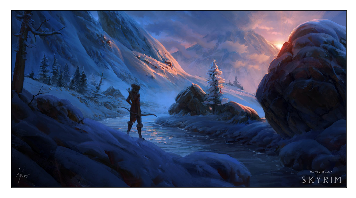

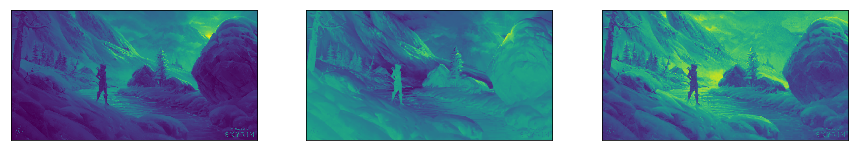

In [38]:
# Show original image
showim(a)

(fig, axes) = plt.subplots(ncols=3, figsize=(15, 6))

# show components
for (i, ax) in enumerate(axes):
    showim(b[:, :, i], ax)
plt.show()

In [69]:
fa = np.fft.fft2(a, axes=(0, 1))
ffa = np.fft.ifft2(fa, axes=(0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


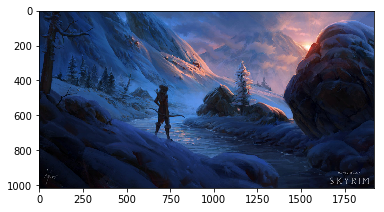

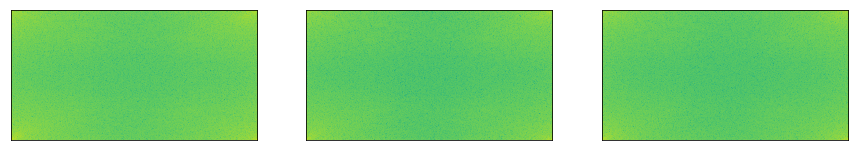

In [78]:
plt.imshow(np.abs(ffa) / 255)

(fig, axes) = plt.subplots(ncols=3, figsize=(15, 6))

# show components
for (i, ax) in enumerate(axes):
    x = np.abs(fa[:, :, i])
    x = (x - x.min()) / (x.max() - x.min())
    showim(np.log(x), ax)
plt.show()

In [70]:
print(np.abs(ffa[:, :, 0]))

[[  1.80000000e+01   1.80000000e+01   1.80000000e+01 ...,   8.20000000e+01
    7.80000000e+01   7.50000000e+01]
 [  1.80000000e+01   1.80000000e+01   1.80000000e+01 ...,   7.70000000e+01
    7.60000000e+01   7.50000000e+01]
 [  1.80000000e+01   1.80000000e+01   1.80000000e+01 ...,   7.30000000e+01
    7.40000000e+01   7.50000000e+01]
 ..., 
 [  7.87762958e-14   7.12664274e-14   7.87389324e-14 ...,   1.10000000e+01
    1.10000000e+01   1.10000000e+01]
 [  8.83778792e-14   6.87308883e-14   8.51805271e-14 ...,   1.20000000e+01
    1.20000000e+01   1.20000000e+01]
 [  1.14528946e-13   9.21535708e-14   1.15408414e-13 ...,   1.40000000e+01
    1.40000000e+01   1.40000000e+01]]


## Histogram

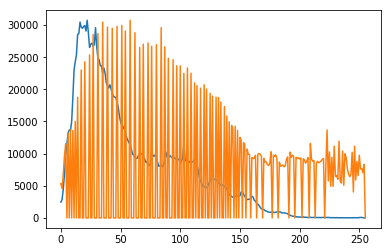

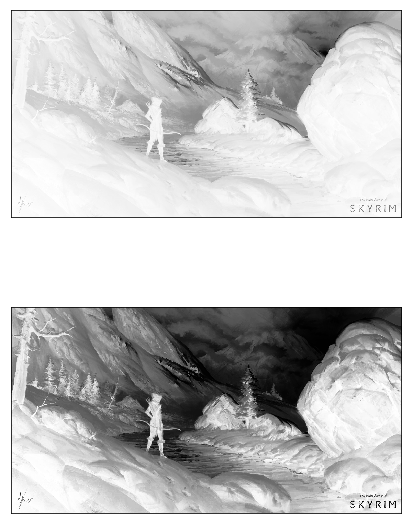

In [98]:
# Gathering luminance
a_gray = np.uint8(b[:, :, 0])
h = np.array([np.sum(a_gray == i) for i in range(256)])
hB = np.array([0 for i in range(256)])

n = a_gray.shape[0] * a_gray.shape[1]
k = 0
j = 0

b_gray = np.zeros(a_gray.shape, dtype='uint8')

for i in range(256):
    k += h[i]
    b_gray[a_gray == i] = 255 * k // n
    hB[255 * k // n] += h[i]

plt.plot(h)
plt.plot(hB)

fig, ax = plt.subplots(nrows=2, figsize=(7, 10))
showim(a_gray, ax[0])
showim(b_gray, ax[1])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


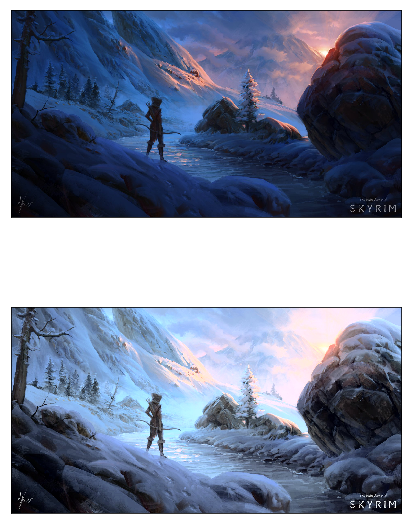

In [109]:
b_yuv = np.copy(b)
b_yuv[:, :, 0] = b_gray

b_cols = np.dot(b_yuv, TO_COLS)

fig, ax = plt.subplots(nrows=2, figsize=(7, 10))
showim(a, ax[0])
showim(b_cols/255, ax[1])
plt.show()

###  Filter

In [157]:
def force2(h, shape):
    a = np.zeros(shape)
    (n, p) = h.shape
    a[-(n//2):, -(p//2):] = h[:n//2, :p//2]
    a[-(n//2):, :p-p//2] = h[:n//2, p//2:]
    
    a[:n-n//2, -(p//2):] = h[n//2:, :p//2]
    a[:n-n//2, :p-p//2] = h[n//2:, p//2:]
    
    return a

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\numpy\fft\fftpack.py:288: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))


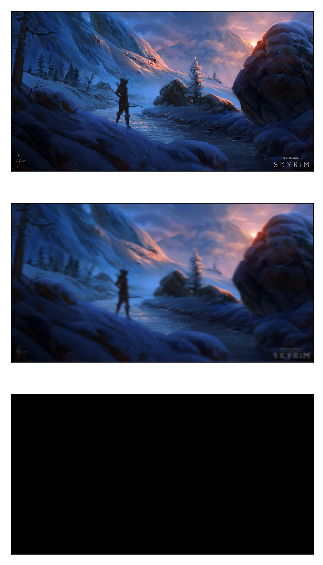

In [184]:
h = np.zeros(a.shape)
h0 = .05 * np.array(
        [
            [1, 1, 1, 1, 1],
            [1, 2, 4, 2, 1],
            [1, 1, 1, 1, 1]
        ])
for i in range(3): 
    h[:, :, i] = force2(h0, a.shape[:2])

H = np.fft.fft2(h, axes=(0, 1))
A = np.fft.fft2(a, axes=(0, 1))

H20 = H ** 20
B20 = A * H20
H20[H20 > 1e-15] = .001 / np.prod(H20.shape)
C20 = B20 / H20

h20 = np.fft.ifft2(H20, axes=(0, 1))

b20 = np.fft.ifft2(B20, axes=(0, 1))
b20 = np.abs(b20 /255)


c20 = np.fft.ifft2(C20, axes=(0, 1))
c20 = np.abs(c20 /255)

fig, ax = plt.subplots(nrows=3, figsize=(15, 10))
showim(a, ax[0])
showim(b20, ax[1])
showim(c20, ax[2])
plt.show()

In [186]:
print(np.abs(c20))
print(np.abs(c20).max())

[[[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]

 [[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]

 [[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]

 ..., 
 [[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]

 [[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]

 [[ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]
  ..., 
  [ nan  nan  nan]
  [ nan  nan  nan]
  [ nan  nan  nan]]]
nan


In [182]:
print(np.sum((np.abs(H20) > 1e-200))/np.prod(H20.shape))

0.999997949475
